# PySAL *segregation* module for spatial indexes

This is an example notebook of functionalities for spatial indexes of the *segregation* module. Firstly, we need to import the packages we need.

In [1]:
%matplotlib inline

import geopandas as gpd
from pysal.explore import segregation
import pysal.lib

Then it's time to load some data to estimate segregation. We use the data of 2000 Census Tract Data for the metropolitan area of Sacramento, CA, USA. 

We use a geopandas dataframe available in PySAL examples repository.

For more information about the data: https://github.com/pysal/pysal.lib/tree/master/pysal.lib/examples/sacramento2

In [2]:
s_map = gpd.read_file(pysal.lib.examples.get_path("sacramentot2.shp"))
s_map.columns

Index(['FIPS', 'MSA', 'TOT_POP', 'POP_16', 'POP_65', 'WHITE_', 'BLACK_',
       'ASIAN_', 'HISP_', 'MULTI_RA', 'MALES', 'FEMALES', 'MALE1664',
       'FEM1664', 'EMPL16', 'EMP_AWAY', 'EMP_HOME', 'EMP_29', 'EMP_30',
       'EMP16_2', 'EMP_MALE', 'EMP_FEM', 'OCC_MAN', 'OCC_OFF1', 'OCC_INFO',
       'HH_INC', 'POV_POP', 'POV_TOT', 'HSG_VAL', 'FIPSNO', 'POLYID',
       'geometry'],
      dtype='object')

The data have several demographic variables. We are going to assess the segregation of the Hispanic Population (variable 'HISP_'). For this, we only extract some columns of the geopandas dataframe.

In [3]:
gdf = s_map[['geometry', 'HISP_', 'TOT_POP']]

We also can plot the spatial distribution of the composition of the Hispanic population over the tracts of Sacramento:

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


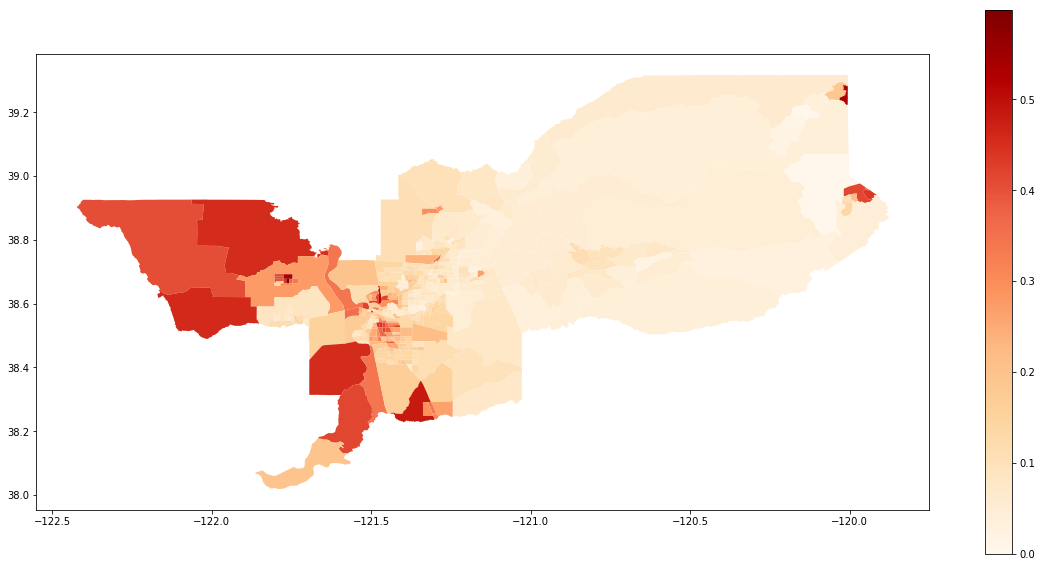

In [4]:
gdf['composition'] = gdf['HISP_'] / gdf['TOT_POP']

gdf.plot(column = 'composition',
         cmap = 'OrRd', 
         figsize=(20,10),
         legend = True)

## Notation

For consistency of notation, we assume that $n_{ij}$ is the population of unit $i \in \{1, ..., I\}$ of group $j \in \{x, y\}$, also $\sum_{j}n_{ij} = n_{i.}$, $\sum_{i}n_{ij} = n_{.j}$, $\sum_{i}\sum_{j}n_{ij} = n_{..}$, $\tilde{s}_{ij} = \frac{n_{ij}}{n_{i.}}$, $\hat{s}_{ij} = \frac{n_{ij}}{n_{.j}}$. The segregation indexes can be build for any group $j$ of the data.

### Spatial Dissimilarity

The Dissimilarity Index (D) is given by:

\begin{equation}
D=\sum_{i=1}^{I}\frac{n_{i.}\mid \tilde{s}_{ij}-\frac{n_{.j}}{n_{..}}\mid}{2n_{..}\frac{n_{.j}}{n_{..}}\left ( 1-\frac{n_{.j}}{n_{..}} \right ).}
\end{equation}

The Spatial Dissimilarity (SD) is given by:

\begin{equation}
SD = D-\frac{\sum_{i_1=1}^{I}\sum_{i_2=1}^{I}\left | \tilde{s}_{ij}^{i_1}-\tilde{s}_{ij}^{i_2} \right |c_{i_1i_2}}{\sum_{i_1=1}^{I}\sum_{i_2=1}^{I}c_{i_1i_2}}
\end{equation}

where $\tilde{s}_{ij}^{i_1}$ and $\tilde{s}_{ij}^{i_2}$ are the proportions of the minority population in the units $i_1$ and $i_2$, respectively and where $c_{i_1i_2}$ denotes an element at $(i_1,i_2)$ in a matrix C, which becomes one only if $i_1$ and $i_2$ are considered neighbors.

The index is fitted below:

In [5]:
from pysal.explore.segregation.spatial_indexes import Spatial_Dissim
index = Spatial_Dissim(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Spatial_Dissim

All the **segregation** classes have the *statistic* and the *core_data* attributes. We can access the point estimation of SD for the data set with the **statistic** attribute:

In [6]:
index.statistic

0.2611974332919437

### Boundary Spatial Dissimilarity

The boundary spatial D (BSD) is given by:

\begin{equation}
BSD = D - \frac{1}{2}{\sum_{i_1=1}^{I}\sum_{i_2=1}^{I}w_{i_1i_2} \left | \tilde{s}_{ij}^{i_1} - \tilde{s}_{ij}^{i_2} \right |}
\end{equation}

where

$$w_{i_1i_2} = \frac{cb_{i_1i_2}}{\sum_{i_2=1}^{I}d_{i_1i_2}}$$

where $\tilde{s}_{ij}^{i_1}$ and $\tilde{s}_{ij}^{i_2}$ are the proportions of the minority population in the units $i_1$ and $i_2$, respectively, and $cb_{i_1i_2}$ is the length of the common boundary of areal units $i_1$ and $i_2$.

The index is fitted below:

In [7]:
from pysal.explore.segregation.spatial_indexes import Boundary_Spatial_Dissim
index = Boundary_Spatial_Dissim(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Boundary_Spatial_Dissim

In [8]:
index.statistic

0.2667626367289605

### Perimeter/Area Ratio Spatial Dissimilarity

The perimeter/area ratio Spatial D (PARD) is a spatial dissimilarity index that takes into consideration the perimeter and the area of each unit by adding a specific multiplicative term in the second term of BSD (the spatial effect):

\begin{equation}
\frac{\frac{1}{2}\left [\left ( \frac{P_i}{A_i} \right )+\left ( \frac{P_j}{A_j} \right )  \right ]}{MAX\left ( \frac{P}{A} \right )}
\end{equation}

where $P_i$ and $A_i$ are the perimeter and area of unit $i$, respectively and $MAX(P/A)$ is the maximum perimeter-area ratio or the minimum compactness of an areal unit found in the study region.

The index is fitted below:

In [9]:
from pysal.explore.segregation.spatial_indexes import Perimeter_Area_Ratio_Spatial_Dissim
index = Perimeter_Area_Ratio_Spatial_Dissim(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Perimeter_Area_Ratio_Spatial_Dissim

In [10]:
index.statistic

0.3165091834802075

### Spatial Proximity Profile

The spatial proximity profile (SPP) is similar to the Concentration Profile, but with the addition of the spatial component in the connecting function.

\begin{equation}
\eta_t = \frac{k^2-k}{\sum_{i_1}\sum_{1_2}\delta_{i_1i_2}}
\end{equation}

where $k$ refers to the sum of $g(t,i)$ for a given $t$ and $\delta_{ij}$ is the distance between $i_1$ and $i_2$. One way of determining $\delta_{i_1i_2}$ would be to use a spatial structure matrix, $W$. The matrix $W$ present ones if $i_1$ and $i_2$ are contiguous and zero, otherwise. The distance $\delta_{i_1i_2}$ between $i_1$ and $i_2$ is given by is the order of how neighbors is needed to reach from $i_1$ to $i_2$. For example, two census tracts, $x_1$ and $x_2$, that do not have a common boundary but both are adjacent to the same unit, $x_3$, are second-order neighbors, so $\delta_{12}$ becomes 2. Like the Concentration Profile, if the number of thresholds used is large enough, a smooth curve, or a *spatial proximity profile*, can be constructed by plotting and connecting $\eta_t$.

So, in the equation, $g(t, i)$ is a logical function that is defined as:

\begin{equation}
  g(t,i) =
  \begin{cases}
    1 & if \ \frac{n_{ij}}{n_{i.}} \geqslant t \\
    0 & \ otherwise.
  \end{cases}
\end{equation}

The Spatial Proximity Profile (SPP) is given by:

\begin{equation}
SPP=\frac{\frac{n_{.j}}{n_{..}}-\left ( \int_{t=0}^{\frac{n_{.j}}{n_{..}}}\eta_tdt - \int_{t=\frac{n_{.j}}{n_{..}}}^{1}\eta_tdt \right )}{1-\frac{n_{.j}}{n_{..}}}.
\end{equation}

The index is fitted below:

In [11]:
from pysal.explore.segregation.spatial_indexes import Spatial_Prox_Prof
index = Spatial_Prox_Prof(gdf, 'HISP_', 'TOT_POP')
type(index)

c:\users\renan\desktop\segregation\segregation\spatial_indexes.py:108: RuntimeWarning: invalid value encountered in long_scalars
  eta_t = (k**2 - k) / den


segregation.spatial_indexes.Spatial_Prox_Prof

In [12]:
index.statistic

0.22847334404621394

In addition, this index has a plotting method to see the profile estimated.

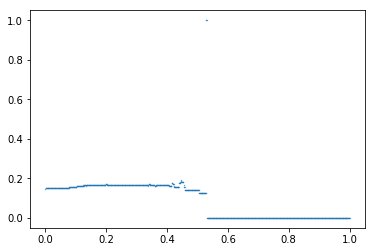

In [13]:
index.plot()

### Spatial Proximity

The Spatial Proximity Index (SP) is given by:

\begin{equation}
SP = \frac{XP_{xx} + YP_{yy}}{TP_{tt}}
\end{equation}

where

\begin{equation*}
P_{xx} = \sum_{i_1=1}^{I}\sum_{i_2=1}^{I}\frac{n_{i_1x}n_{i_2x}\zeta_{i_1i_2}}{n_{.x}^2}
\end{equation*}

\begin{equation*}
P_{yy} = \sum_{i_1=1}^{I}\sum_{i_2=1}^{I}\frac{n_{i_1y}n_{i_2y}\zeta_{i_1i_2}}{n_{.y}^2}
\end{equation*}

\begin{equation*}
P_{tt} = \sum_{i_1=1}^{I}\sum_{i_2=1}^{I}\frac{n_{i_1.}n_{i_2.}\zeta_{i_1i_2}}{n_{..}^2}
\end{equation*}

\begin{equation*}
\zeta_{i_1i_2} = exp(-d_{i_1i_2})
\end{equation*}

$d_{i_1i_2}$ is a pairwise distance measure between area $i_1$ and $i_2$ and $d_{ii}$ is estimated as $d_{ii} = (\alpha a_i)^{\beta}$ where $a_i$ is the area of unit $i$. The default is $\alpha = 0.6$ and $\beta = 0.5$ and for the distance measure, we first extracts the centroid of each unit and calculate the euclidean distance.

The index is fitted below (note you can choose alpha and beta):

In [14]:
from pysal.explore.segregation.spatial_indexes import Spatial_Proximity
index = Spatial_Proximity(gdf, 'HISP_', 'TOT_POP', alpha = 0.6, beta = 0.5)
type(index)

segregation.spatial_indexes.Spatial_Proximity

In [15]:
index.statistic

1.0026623464135092

### Relative Clustering

The Relative Clustering Measure (RCL) is given by:

\begin{equation}
RCL = \frac{P_{xx}}{P_{yy}} - 1
\end{equation}

The index is fitted below (note you can choose alpha and beta):

In [16]:
from pysal.explore.segregation.spatial_indexes import Relative_Clustering
index = Relative_Clustering(gdf, 'HISP_', 'TOT_POP', alpha = 0.6, beta = 0.5)
type(index)

segregation.spatial_indexes.Relative_Clustering

In [17]:
index.statistic

0.009095632468738568

### Spatial Isolation

The Spatial Isolation (SxPx), also known as Distance-Decay Isolation, is given by:

\begin{equation}
SxPx=\sum_{i_1=1}^{I}\left ( \hat{s}_{i_1x} \right )\left (\sum_{i_2=1}^{I}P_{i_1i_2} \left (\tilde{s}_{i_1x}\right ) \right )
\end{equation}

where

\begin{equation*}
P_{i_1i_2} = \frac{\zeta_{i_1i_2}n_{i_2.}}{\sum_{i_2=1}^{I}\zeta_{i_1i_2}n_{i_2.}}
\end{equation*}

such that

\begin{equation*}
\sum_{i_2=1}^{I}P_{i_1i_2} = 1.
\end{equation*}

where $\zeta_{i_1i_2}$ is defined as before. This also could be seen as the *probability of contact* of members of group $x$ to each other weighted by the inverse of distance.

The index is fitted below (note you can choose alpha and beta):

In [18]:
from pysal.explore.segregation.spatial_indexes import Spatial_Isolation
index = Spatial_Isolation(gdf, 'HISP_', 'TOT_POP', alpha = 0.6, beta = 0.5)
type(index)

segregation.spatial_indexes.Spatial_Isolation

In [19]:
index.statistic

0.1562162475606278

### Spatial Exposure

The Spatial Exposure (SxPy), also known as Distance-Decay Exposure, is given by:

\begin{equation}
SxPy=\sum_{i_1=1}^{I}\left ( \hat{s}_{i_1x} \right )\left (\sum_{i_2=1}^{I}P_{i_1i_2} \left (\tilde{s}_{i_1y}\right ) \right )
\end{equation}

where $P_{i_1i_2}$ is defined as before.

The index is fitted below (note you can choose alpha and beta):

In [20]:
from pysal.explore.segregation.spatial_indexes import Spatial_Exposure
index = Spatial_Exposure(gdf, 'HISP_', 'TOT_POP', alpha = 0.6, beta = 0.5)
type(index)

segregation.spatial_indexes.Spatial_Exposure

In [21]:
index.statistic

0.8396583368412371

### Delta

The Delta (DEL) measure is given by the following equation:

\begin{equation}
DEL = \frac{1}{2}\sum_{i=1}^{I}\left | \hat{s}_{ij} - \frac{a_i}{A} \right |
\end{equation}

where $a_i$ is the area of unit $i$ and $A$ is the total area of the given region $A = \sum_{i=1}^{I}a_i$.

The index is fitted below:

In [22]:
from pysal.explore.segregation.spatial_indexes import Delta
index = Delta(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Delta

In [23]:
index.statistic

0.8044969214141899

### Absolute Concentration

The Absolute Concentration Index (ACO) is given by:

\begin{equation}
\large
ACO = 1-\frac{ \sum_{i=1}^{I}\left ( \frac{n_{ij}a_i}{n_{.j}} \right ) - \sum_{i=1}^{n_1}\left ( \frac{n_{i.}a_i}{T_1} \right )}{ \sum_{i=n_2}^{I}\left ( \frac{n_{i.}a_i}{T_2} \right ) - \sum_{i=1}^{n_1}\left ( \frac{n_{i.}a_i}{T_1} \right )}
\end{equation}

where the units are **ordered** from **smallest to largest** in areal size. In this formula, $n_1$ is the rank of the unit where the cumulative total population equal the total minority population, $n_2$ is the rank of the unit where cumulative total population equal equal the total minority population **from the largest unit down**. In addition,

\begin{equation*}
T_1 = \sum_{i=1}^{n_1}n_{i.}
\end{equation*}

and

\begin{equation*}
T_2 = \sum_{i=n_2}^{n}n_{i.}
\end{equation*}

The index is fitted below:

In [24]:
from pysal.explore.segregation.spatial_indexes import Absolute_Concentration
index = Absolute_Concentration(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Absolute_Concentration

In [25]:
index.statistic

0.21496583971774408

### Relative Concentration

The Relative Concentration Index (RCO) is given by:

\begin{equation}
\large
RCO = \frac{\frac{\sum_{i=1}^{I}\left ( \frac{n_{ix}a_i}{n_{.x}} \right )}{\sum_{i=1}^{I}\left ( \frac{n_{iy}a_i}{n_{.y}} \right )}-1}{\frac{\sum_{i=1}^{n_1}\left ( \frac{n_{i.}a_i}{T_1} \right )}{\sum_{i=n_2}^{I}\left ( \frac{n_{i.}a_i}{T_2} \right )}-1}
\end{equation}

where $n_1$, $n_2$, $T_1$ and $T_2$ are defined as before.

The index is fitted below:

In [26]:
from pysal.explore.segregation.spatial_indexes import Relative_Concentration
index = Relative_Concentration(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Relative_Concentration

In [27]:
index.statistic

0.13102848628073688

### Absolute Centralization and Relative Centralization

The degree of centralization can be evaluated through the Absolute Centralization Index (ACE) or through the Relative Centralization Index (RCE):

\begin{equation}
ACE=\left ( \sum_{i=2}^{I}X_{i-1}A_i \right ) - \left ( \sum_{i=2}^{I}X_{i}A_{i-1} \right )
\end{equation}

\begin{equation}
RCE=\left ( \sum_{i=2}^{I}X_{i-1}Y_i \right ) - \left ( \sum_{i=2}^{I}X_{i}Y_{i-1} \right )
\end{equation}

where $A_i$ is the cumulative area proportion through unit $i$, $X_i$ is the cumulative frequency proportion through unit $i$ of group $x$ and $Y_i$ is the analogous for group $y$. In this measure, the area units are ordered by increasing distances from the central business district, which we assume being located in the average latitude and average longitude among all centroid.

The ACE is fitted below:

In [28]:
from pysal.explore.segregation.spatial_indexes import Absolute_Centralization
index = Absolute_Centralization(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Absolute_Centralization

In [29]:
index.statistic

0.6891422368736286

The RCE is fitted below:

In [30]:
from pysal.explore.segregation.spatial_indexes import Relative_Centralization
index = Relative_Centralization(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Relative_Centralization

In [31]:
index.statistic

-0.11194177550430595

### Spatial Information Theory

The Spatial Information Theory (SIT), inspired by *Reardon, Sean F., and David O’Sullivan. "Measures of spatial segregation." Sociological methodology 34.1 (2004): 121-162.* takes into consideration the local environment of each spatial unit. The spatially weighted entropy of unit $i$ is given by

$$\tilde{E}_i = \sum_{j}\frac{\tilde{n_{ij}}}{\tilde{n_{i.}}} \times \log_2\left ( \frac{\tilde{n_{ij}}}{\tilde{n_{i.}}} \right )$$
where $\tilde{n_{ij}}$ is the population frequency of unit $i$ of group $j$ around the local environment of $i$ and $\tilde{n_{i.}}$ is the total population of the local environment of $i$.

The overall regional entropy of the total population given by

$$E = \sum_{j}\frac{n_{.j}}{n_{..}} \times \log_2\left ( \frac{n_{.j}}{n_{..}} \right )$$

and the SIT is given by

$$SIT = 1 - \frac{1}{TE}\sum_{i = 1}^{I}\tau_i\tilde{E}_i$$
where $\tau_i$ is the population density at the unit $i$.

In [32]:
from pysal.explore.segregation.spatial_indexes import Spatial_Information_Theory
index = Spatial_Information_Theory(gdf, 'HISP_', 'TOT_POP')
type(index)

segregation.spatial_indexes.Spatial_Information_Theory

In [33]:
index.statistic

0.778177518074913